# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [1]:
#import libraries needed
import pandas as pd
import numpy as np
import requests
import tweepy
import json

In [2]:
df = pd.read_csv('twitter-archive-enhanced.csv')

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open('image_predictions.tsv', mode = 'wb') as file:
    file.write(response.content)
    
image = pd.read_csv('image_predictions.tsv', sep = '\t')

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [4]:
y = []
with open('tweet-json.txt', 'r') as json_file:
    for x in json_file:
        json_data = json.loads(x)
        y.append({'tweet_id': json_data['id'],
                  'retweet_count': json_data['retweet_count'],
                  'favorite_count': json_data['favorite_count']})
tweet = pd.DataFrame(y, columns=['tweet_id','retweet_count','favorite_count'])

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



### Visual Assessments

In [5]:
df
#also used excel to visually review the data 

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [6]:
image
#also used txt file to visually review the data

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [7]:
tweet
#also used txt file to visually review the data

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


### Programmatic Assessment

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [9]:
image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [10]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [11]:
image.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [12]:
df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [13]:
df.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

In [14]:
df['source'].unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

In [15]:
image.nunique()

tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

In [16]:
image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### Quality issues
1. There are only 2,009 unique jpg_url's in the image data frame. As we would expect for there to be 2,075 unique jpg_url's this could be indicative of repeated images used.

2. The timestamp in df, is an object and not datetime format. So that we can sort and categorize by dates.

3. From a quick look through the image predictions data, it appears some dog types identified do not exist such as 'orange', 'paper_towel', and 'bagel.' As these are not dog type, they should be excluded.

4. From the retweet and reply status in df, appears that there are some retweeted and reply tweets and should not be included.

5. As some of the tweets are beyond 8/1/2017 and there are no predictions on these tweets, we should exclude these from the population.

6. Some tweets appear to not have come from twitter and from vine. To keep the analysis consistent, we should only keep those that come from twitter.

7. In the image, there is inconsistant uses of upper and lower case lettering.

8. After the cleaning before merging the files, there are some columns that are not needed and can be dropped.

### Tidiness issues
1. The dog stage is one variable and should be in one column, not 4.

2. The three different files/ datagrames are information about one type of observational unit thus should be on one dataframe.

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [17]:
# Make copies of original pieces of data
df_clean = df.copy()
image_clean = image.copy()
tweet_clean = tweet.copy()

### Issue #1: There are only 2,009 unique jpg_url's in the image data frame. As we would expect for there to be 2,075 unique jpg_url's this could be indicative of repeated images used.

#### Define
- Remove duplicated jpg_urls in image data frame

#### Code

In [18]:
image_clean[image_clean.jpg_url.duplicated() == True].tweet_id

1297    752309394570878976
1315    754874841593970688
1333    757729163776290825
1345    759159934323924993
1349    759566828574212096
               ...        
1903    851953902622658560
1944    861769973181624320
1992    873697596434513921
2041    885311592912609280
2055    888202515573088257
Name: tweet_id, Length: 66, dtype: int64

In [19]:
#I want to keep one of the each of the tweet_id's above so should have 2009 after cleaning
# based code off of https://stackoverflow.com/questions/12497402/remove-duplicates-by-columns-a-keeping-the-row-with-the-highest-value-in-column
image_clean = image_clean.drop_duplicates(subset='jpg_url', keep="first").reset_index(drop = True)

#### Test

In [20]:
image_clean[image_clean.jpg_url.duplicated() == True].tweet_id

Series([], Name: tweet_id, dtype: int64)

In [21]:
image_clean.info()
#frame has 2009 rows 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2009 entries, 0 to 2008
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2009 non-null   int64  
 1   jpg_url   2009 non-null   object 
 2   img_num   2009 non-null   int64  
 3   p1        2009 non-null   object 
 4   p1_conf   2009 non-null   float64
 5   p1_dog    2009 non-null   bool   
 6   p2        2009 non-null   object 
 7   p2_conf   2009 non-null   float64
 8   p2_dog    2009 non-null   bool   
 9   p3        2009 non-null   object 
 10  p3_conf   2009 non-null   float64
 11  p3_dog    2009 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 147.3+ KB


In [22]:
image_clean.nunique()
#each row has a unique tweet_id

tweet_id    2009
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

### Issue #2: The timestamp in df, is an object and not datetime format. So that we can sort and categorize by dates.

#### Define
- converting the time stamp from object to datetime format

#### Code

In [23]:
#before cleaning the time stamps
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [24]:
df_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [25]:
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])

#### Test

In [26]:
#the type has changed to datetime
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   int64              
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

In [27]:
df_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Issue #3: From a quick look through the image predictions data, it appears some dog types identified do not exist such as 'orange', 'paper_towel', and 'bagel.' As these are not dog type, they should be excluded.

#### Define:
- remove rows from image that have predictors that are not a dog bread

#### Code

In [28]:
#identify what are included in the p1 column and how many in each
breed_1 = image_clean['p1'].value_counts()

#exported as an excel to be able to read the full list easily
breed_1.to_csv('breeds_1.csv')

Per review of the listing, it appears that all counts 10 and above are dog breeds.
As there are only a few dog breeds within the counts 9 and below, I will mannually go though and exclude those from the non dog listing below

In [29]:
#listing of non dog breeds
non_breeds_1 = ["dingo", "tennis_ball", "doormat", "Siamese_cat", "bath_towel", "tub", "hamster", "swing", "home_theater", "llama", "ice_bear", "car_mirror", "porcupine", "shopping_cart", "ox", "minivan", "hippopotamus", "brown_bear", "hog", "bow_tie", "wombat", "jigsaw_puzzle", "barrow", "Arctic_fox", "patio", "Mexican_hairless", "bluetick", "bathtub", "guinea_pig", "goose", "balloon", "muzzle", "briard", "prison", "wood_rabbit", "mousetrap", "refrigerator", "sea_lion", "toilet_tissue", "stone_wall", "white_wolf", "motor_scooter", "space_heater", "ram", "cowboy_hat", "dishwasher", "vacuum", "triceratops", "Christmas_stocking", "ski_mask", "common_iguana", "washbasin", "Arabian_camel", "cairn", "window_shade", "Ibizan_hound", "jack-o'-lantern", "comic_book", "seashore", "Brabancon_griffon", "gas_pump", "jellyfish", "shower_curtain", "lakeside", "tusker", "bustard", "acorn_squash", "hen", "paper_towel", "koala", "bubble", "leatherback_turtle", "Angora", "wire-haired_fox_terrier", "cash_machine", "wallaby", "paddle", "frilled_lizard", "street_sign", "toyshop", "dough", "upright", "birdhouse", "tabby", "axolotl", "snorkel", "dogsled", "hermit_crab", "snail", "hyena", "meerkat", "geyser", "feather_boa", "Loafer", "Appenzeller", "weasel", "chimpanzee", "laptop", "badger", "sorrel", "Sussex_spaniel", "wool", "ostrich", "box_turtle", "gondola", "tiger_shark", "bib", "binoculars", "sulphur-crested_cockatoo", "coil", "agama", "wild_boar", "traffic_light", "hotdog", "handkerchief", "espresso", "cup", "bonnet", "polecat", "alp", "coho", "hammer", "studio_couch", "cliff", "timber_wolf", "nail", "lawn_mower", "three-toed_sloth", "sunglasses", "desktop_computer", "rapeseed", "hand_blower", "peacock", "American_black_bear", "loupe", "school_bus", "cowboy_boot", "jersey", "wooden_spoon", "leopard", "mortarboard", "teapot", "military_uniform", "washer", "coffee_mug", "fountain", "pencil_box", "barbell", "grille", "revolver", "envelope", "syringe", "marmot", "pole", "basketball", "tricycle", "convertible", "limousine", "restaurant", "shield", "rotisserie", "bookcase", "conch", "skunk", "bookshop", "radio_telescope", "cougar", "African_grey", "coral_reef", "lion", "maillot", "Madagascar_cat", "Egyptian_cat", "silky_terrier", "giant_panda", "long-horned_beetle", "clumber", "sundial", "padlock", "pool_table", "quilt", "beach_wagon", "remote_control", "bakery", "pedestal", "four-poster", "cheeseburger", "otter", "suit", "killer_whale", "terrapin", "cuirass", "microwave", "starfish", "sandbar", "leaf_beetle", "lynx", "water_bottle", "toilet_seat", "shopping_basket", "robin", "crash_helmet", "slug", "soccer_ball", "African_crocodile", "tick", "ocarina", "bearskin", "bow", "carton", "candle", "bee_eater", "china_cabinet", "banana", "dhole", "sea_urchin", "lacewing", "ping-pong_ball", "platypus", "scorpion", "flamingo", "microphone", "mud_turtle", "pitcher", "African_hunting_dog", "boathouse", "picket_fence", "pot", "zebra", "piggy_bank", "park_bench", "prayer_rug", "stove", "king_penguin", "tailed_frog", "snowmobile", "ibex", "electric_fan", "sliding_door", "damselfly", "hare", "fiddler_crab", "bannister", "crane", "Scotch_terrier", "bighorn", "standard_schnauzer", "bison", "ice_lolly", "hay", "dining_table", "groenendael", "beaver", "swab", "grey_fox", "hummingbird", "clog", "fire_engine", "minibus", "cheetah", "walking_stick", "canoe", "trombone", "book_jacket", "rain_barrel", "black-footed_ferret", "guenon", "Japanese_spaniel", "water_buffalo", "maze", "harp", "panpipe", "mailbox", "EntleBucher", "earthstar", "pillow", "carousel", "bald_eagle", "lorikeet", "orange"]

#to drop columns that include these non breeds
image_clean = image_clean[image_clean.p1.isin(non_breeds_1) == False]

Repeated steps for p2 and p3 below

In [30]:
breed_2 = image_clean['p2'].value_counts()

breed_2.to_csv('breeds_2.csv')

In [31]:
non_breeds_2 = ["crossword_puzzle", "jean", "monitor", "cradle", "bathing_cap", "mongoose", "wig", "table_lamp", "gibbon", "Persian_cat", "lighter", "hand-held_computer", "computer_keyboard", "sleeping_bag", "chain_saw", "corn", "waffle_iron", "quill", "junco", "otterhound", "crib", "hair_slide", "komondor", "oscilloscope", "red_fox", "mashed_potato", "menu"]

image_clean = image_clean[image_clean.p2.isin(non_breeds_2) == False]

In [32]:
breed_3 = image_clean['p3'].value_counts()

breed_3.to_csv('breeds_3.csv')

In [33]:
non_breeds_3 = ["menu", "mitten", "golfcart", "soap_dispenser", "bucket", "can_opener", "croquet_ball", "paintbrush", "grocery_store", "television", "shower_cap", "sombrero", "chest", "purse", "greenhouse", "komondor", "shovel", "nipple", "steam_locomotive", "red_wolf", "bathing_cap", "titi", "fur_coat", "Indian_elephant"]

image_clean = image_clean[image_clean.p3.isin(non_breeds_3) == False]
image_clean = image_clean.reset_index(drop = True)

#### Test

In [34]:
#check the listing of the unique values in p1
# listing appears to only include dog breeds
image_clean.p1.unique()

array(['Welsh_springer_spaniel', 'redbone', 'German_shepherd',
       'Rhodesian_ridgeback', 'miniature_pinscher',
       'Bernese_mountain_dog', 'golden_retriever', 'Gordon_setter',
       'Walker_hound', 'pug', 'bloodhound', 'Lhasa', 'English_setter',
       'Italian_greyhound', 'Maltese_dog', 'malamute',
       'soft-coated_wheaten_terrier', 'Chihuahua',
       'black-and-tan_coonhound', 'toy_terrier', 'Blenheim_spaniel',
       'Pembroke', 'curly-coated_retriever', 'dalmatian', 'Border_collie',
       'Labrador_retriever', 'miniature_poodle', 'seat_belt',
       'miniature_schnauzer', 'Airedale', 'Chesapeake_Bay_retriever',
       'West_Highland_white_terrier', 'toy_poodle', 'giant_schnauzer',
       'vizsla', 'Rottweiler', 'Siberian_husky', 'teddy', 'papillon',
       'Saint_Bernard', 'Tibetan_terrier', 'borzoi', 'beagle',
       'Yorkshire_terrier', 'Pomeranian', 'web_site', 'kuvasz',
       'flat-coated_retriever', 'Norwegian_elkhound', 'chow',
       'standard_poodle', 'Staffor

In [35]:
#check the listing of the unique values in p2
# listing appears to only include dog breeds
image_clean.p2.unique()

array(['collie', 'miniature_pinscher', 'malinois', 'redbone',
       'Rottweiler', 'English_springer', 'Tibetan_mastiff',
       'Yorkshire_terrier', 'English_foxhound', 'bull_mastiff',
       'German_shepherd', 'Shih-Tzu', 'Newfoundland', 'toy_terrier',
       'toy_poodle', 'Chesapeake_Bay_retriever', 'Siberian_husky',
       'Afghan_hound', 'bloodhound', 'papillon', 'cocker_spaniel', 'chow',
       'beagle', 'giant_schnauzer', 'Labrador_retriever', 'Chihuahua',
       'Weimaraner', 'Brittany_spaniel', 'standard_schnauzer', 'teddy',
       'vizsla', 'pug', 'Italian_greyhound', 'Samoyed', 'Pomeranian',
       'miniature_poodle', 'Lakeland_terrier', 'Irish_setter', 'malamute',
       'bath_towel', 'Border_collie', 'Leonberg', 'French_bulldog',
       'Irish_terrier', 'ice_bear', 'Christmas_stocking',
       'golden_retriever', 'standard_poodle', 'kuvasz', 'Cardigan',
       'silky_terrier', 'Pembroke', 'dishwasher', 'English_setter',
       'Pekinese', 'hog', 'cowboy_boot', 'minivan', '

In [36]:
#check the listing of the unique values in p3
# listing appears to only include dog breeds
image_clean.p3.unique()

array(['Shetland_sheepdog', 'Rhodesian_ridgeback', 'bloodhound',
       'miniature_pinscher', 'Doberman', 'Greater_Swiss_Mountain_dog',
       'Labrador_retriever', 'Pekinese', 'Ibizan_hound', 'French_bulldog',
       'malinois', 'Dandie_Dinmont', 'borzoi', 'basenji',
       'miniature_poodle', 'Eskimo_dog', 'briard', 'papillon',
       'flat-coated_retriever', 'Chihuahua', 'Shih-Tzu', 'Pomeranian',
       'Saluki', 'Great_Pyrenees', 'collie', 'toy_poodle', 'vizsla',
       'giant_schnauzer', 'West_Highland_white_terrier', 'teddy',
       'seat_belt', 'kelpie', 'Brabancon_griffon', 'standard_poodle',
       'beagle', 'Irish_water_spaniel', 'bluetick', 'Weimaraner',
       'Chesapeake_Bay_retriever', 'black-and-tan_coonhound', 'kuvasz',
       'Christmas_stocking', 'golden_retriever',
       'Staffordshire_bullterrier', 'Yorkshire_terrier',
       'Lakeland_terrier', 'weasel', 'ski_mask', 'cocker_spaniel',
       'Australian_terrier', 'oscilloscope', 'ice_bear', 'Great_Dane',
       'cu

### Issue #4: From the retweet and reply status in df, appears that there are some retweeted and reply tweets and should not be included.

#### Define
- remove rows that have a retweet status
- remove rows that have a reply status

#### Code

In [37]:
df_clean.info()
# there are 181 retweeted and 78 reply rows still in df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   int64              
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

In [38]:
#based code off of https://stackoverflow.com/questions/27727926/pandas-remove-rows-with-non-blank-values-per-a-field-from-a-dataframe-python-3

df_clean = df_clean[pd.isnull(df_clean['in_reply_to_status_id'])]
df_clean = df_clean[pd.isnull(df_clean['retweeted_status_id'])]

In [39]:
#to reset index
df_clean = df_clean.reset_index(drop = True)

#### Test

In [40]:
df_clean.info()
#no replies or retweets

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2097 non-null   int64              
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   2097 non-null   datetime64[ns, UTC]
 4   source                      2097 non-null   object             
 5   text                        2097 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2094 non-null   object             
 10  rating_numerator            2097 non-null   int64           

### Issue #5: As some of the tweets are beyond 8/1/2017 and there are no predictions on these tweets, we should exclude these from the population.

#### Define
- remove rows in df after 8/1/2017

#### Code

In [41]:
df_clean[df_clean['timestamp'] > '8/1/2017']
#we need to remove 2 rows

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [42]:
df_clean.info()
#after cleaning should have 2,095 total rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2097 non-null   int64              
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   2097 non-null   datetime64[ns, UTC]
 4   source                      2097 non-null   object             
 5   text                        2097 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2094 non-null   object             
 10  rating_numerator            2097 non-null   int64           

In [43]:
df_clean = df_clean[df_clean['timestamp'] <= '8/1/2017'].reset_index(drop = True)

#### Test

In [44]:
df_clean[df_clean['timestamp'] > '8/1/2017']
#no rows appear for after 8/1/20217

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [45]:
df_clean.info()
#two rows were removed, total rows not 2,095

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2095 entries, 0 to 2094
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2095 non-null   int64              
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   2095 non-null   datetime64[ns, UTC]
 4   source                      2095 non-null   object             
 5   text                        2095 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2092 non-null   object             
 10  rating_numerator            2095 non-null   int64           

### Issue #6: Some tweets appear to not have come from twitter and from vine. To keep the analysis consistent, we should only keep those that come from twitter.

#### Define
- remove rows that are from vine

#### Code

In [46]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2095 entries, 0 to 2094
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2095 non-null   int64              
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   2095 non-null   datetime64[ns, UTC]
 4   source                      2095 non-null   object             
 5   text                        2095 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2092 non-null   object             
 10  rating_numerator            2095 non-null   int64           

In [47]:
df_clean['source'].unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

In [48]:
df_clean[df_clean['source'] == '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>'].shape[0]

91

In [49]:
df_clean = df_clean[df_clean['source'] != '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>']

In [50]:
df_clean = df_clean.reset_index(drop = True)


#### Test

In [51]:
df_clean.info()
#has a total of 2004 which is 91 rows less

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2004 entries, 0 to 2003
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2004 non-null   int64              
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   2004 non-null   datetime64[ns, UTC]
 4   source                      2004 non-null   object             
 5   text                        2004 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2001 non-null   object             
 10  rating_numerator            2004 non-null   int64           

In [52]:
df_clean['source'].unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

### Issue #7: In the image, there is inconsistent uses of upper and lower case lettering.

#### Define
- convert all values in P1, P2, and P3 to lowercase

#### Code

In [53]:
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1444 entries, 0 to 1443
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1444 non-null   int64  
 1   jpg_url   1444 non-null   object 
 2   img_num   1444 non-null   int64  
 3   p1        1444 non-null   object 
 4   p1_conf   1444 non-null   float64
 5   p1_dog    1444 non-null   bool   
 6   p2        1444 non-null   object 
 7   p2_conf   1444 non-null   float64
 8   p2_dog    1444 non-null   bool   
 9   p3        1444 non-null   object 
 10  p3_conf   1444 non-null   float64
 11  p3_dog    1444 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 105.9+ KB


In [54]:
image_clean['p1'] = image_clean['p1'].str.lower()
image_clean['p2'] = image_clean['p2'].str.lower()
image_clean['p3'] = image_clean['p3'].str.lower()

#### Test

In [55]:
image_clean.sample(5)
#from the sample, all p1, p2, and p3 columns are lower case

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1329,859607811541651456,https://pbs.twimg.com/media/C-3wvtxXcAUTuBE.jpg,1,golden_retriever,0.895529,True,irish_setter,0.024099,True,labrador_retriever,0.019285,True
155,670403879788544000,https://pbs.twimg.com/media/CU3AxW1WoAA3_35.jpg,1,pug,0.802223,True,french_bulldog,0.172557,True,bull_mastiff,0.007163,True
1244,832397543355072512,https://pbs.twimg.com/media/C41FIiAW8AA7lMr.jpg,1,pekinese,0.988916,True,brabancon_griffon,0.001677,True,siamese_cat,0.001126,False
811,740359016048689152,https://pbs.twimg.com/media/CkZImGVUoAAwv0b.jpg,1,golden_retriever,0.863687,True,kuvasz,0.048590,True,labrador_retriever,0.047397,True
219,672488522314567680,https://pbs.twimg.com/media/CVUovvHWwAAD-nu.jpg,1,doberman,0.605358,True,rottweiler,0.108382,True,appenzeller,0.077798,True


### Issue #8: The dog stage is one variable and should be in one column, not 4.

#### Define
- concate the 4 columns of doggo, floofer, pupper, and puppo into one column

#### Code

In [56]:
#first replace all none in each of the columns into empty
df_clean['doggo'] = df_clean['doggo'].replace('None', '')
df_clean['floofer'] = df_clean['floofer'].replace('None', '')
df_clean['pupper'] = df_clean['pupper'].replace('None', '')
df_clean['puppo'] = df_clean['puppo'].replace('None', '')

#combining all into one column
df_clean['dog_stage'] = df_clean['doggo'] + df_clean['floofer'] + df_clean['pupper'] + df_clean['puppo']

#see how much cleaning is neeed after combining
df_clean['dog_stage'].unique()

array(['', 'doggo', 'puppo', 'pupper', 'floofer', 'doggopuppo',
       'doggofloofer', 'doggopupper'], dtype=object)

In [57]:
#clean the '' to be np.nan
df_clean['dog_stage'] = df_clean['dog_stage'].replace('', np.nan, regex=True)

In [58]:
#clean those that are two stages together
df_clean.loc[df_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo,pupper' 
df_clean.loc[df_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo,puppo' 
df_clean.loc[df_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo,floofer'

df_clean['dog_stage'].unique()

array([nan, 'doggo', 'puppo', 'pupper', 'floofer', 'doggo,puppo',
       'doggo,floofer', 'doggo,pupper'], dtype=object)

#### Test

In [59]:
df_clean.sample(6)
#from the sample appears to be proper

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stage
89,872122724285648897,NaN,NaN,2017-06-06 16:07:15+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Kody. He's a baller. Wishes he was a l...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/872122724...,12,10,Kody,,,,,NaN
1862,668620235289837568,NaN,NaN,2015-11-23 02:41:01+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Kallie. There was a tornado in th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668620235...,10,10,Kallie,,,,,NaN
448,800018252395122689,NaN,NaN,2016-11-19 16:49:49+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo doin a struggle. 11/10 much det...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/800018252...,11,10,None,doggo,,,,doggo
9,889880896479866881,NaN,NaN,2017-07-25 16:11:53+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Bruno. He is a service shark. Only get...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889880896...,13,10,Bruno,,,,,NaN
618,770655142660169732,NaN,NaN,2016-08-30 16:11:18+00:00,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Pls stop sending in non-can...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/770655142...,11,10,very,,,,,NaN
907,724046343203856385,NaN,NaN,2016-04-24 01:24:35+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Sarge. Not even he knows what his tong...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/724046343...,10,10,Sarge,,,,,NaN


### Issue #9: After the cleaning before merging the files, there are some columns that are not needed and can be dropped.

#### Define
- drop unnecessary columns in the df dataframe
- drop unnecessary columns in the image dataframe

#### Code

In [60]:
df_clean = df_clean.drop(columns = ['in_reply_to_status_id', 'in_reply_to_user_id', 'source', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls'])

image_clean = image_clean.drop(columns= ['jpg_url', 'img_num'])

#### Test

In [61]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2004 entries, 0 to 2003
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2004 non-null   int64              
 1   timestamp           2004 non-null   datetime64[ns, UTC]
 2   text                2004 non-null   object             
 3   rating_numerator    2004 non-null   int64              
 4   rating_denominator  2004 non-null   int64              
 5   name                2004 non-null   object             
 6   doggo               2004 non-null   object             
 7   floofer             2004 non-null   object             
 8   pupper              2004 non-null   object             
 9   puppo               2004 non-null   object             
 10  dog_stage           310 non-null    object             
dtypes: datetime64[ns, UTC](1), int64(3), object(7)
memory usage: 172.3+ KB


In [62]:
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1444 entries, 0 to 1443
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1444 non-null   int64  
 1   p1        1444 non-null   object 
 2   p1_conf   1444 non-null   float64
 3   p1_dog    1444 non-null   bool   
 4   p2        1444 non-null   object 
 5   p2_conf   1444 non-null   float64
 6   p2_dog    1444 non-null   bool   
 7   p3        1444 non-null   object 
 8   p3_conf   1444 non-null   float64
 9   p3_dog    1444 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(3)
memory usage: 83.3+ KB


### Issue #10: The three different files/ datagrames are information about one type of observational unit thus should be on one dataframe.

#### Define
- use the image data frame as the base to combine all the data frames

#### Code

In [63]:
df_master = image_clean.merge(df_clean, how='inner', on='tweet_id')

In [64]:
df_master = df_master.merge(tweet_clean, how = 'inner', on='tweet_id')

#### Test

In [65]:
df_master

,tweet_id,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,...,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stage,retweet_count,favorite_count
0,666020888022790149,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True,...,8,10,None,,,,,NaN,532,2535
1,666029285002620928,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True,...,7,10,a,,,,,NaN,48,132
2,666033412701032449,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,...,9,10,a,,,,,NaN,47,128
3,666044226329800704,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,...,6,10,a,,,,,NaN,147,311
4,666049248165822465,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True,...,5,10,None,,,,,NaN,41,111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418,890240255349198849,pembroke,0.511319,True,cardigan,0.451038,True,chihuahua,0.029248,True,...,14,10,Cassie,doggo,,,,doggo,7711,32467
1419,890609185150312448,irish_terrier,0.487574,True,irish_setter,0.193054,True,chesapeake_bay_retriever,0.118184,True,...,13,10,Zoey,,,,,NaN,4429,28226
1420,890729181411237888,pomeranian,0.566142,True,eskimo_dog,0.178406,True,pembroke,0.076507,True,...,13,10,None,,,,,NaN,16716,56848
1421,891327558926688256,basset,0.555712,True,english_springer,0.225770,True,german_short-haired_pointer,0.175219,True,...,12,10,Franklin,,,,,NaN,9774,41048


In [66]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1423 entries, 0 to 1422
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1423 non-null   int64              
 1   p1                  1423 non-null   object             
 2   p1_conf             1423 non-null   float64            
 3   p1_dog              1423 non-null   bool               
 4   p2                  1423 non-null   object             
 5   p2_conf             1423 non-null   float64            
 6   p2_dog              1423 non-null   bool               
 7   p3                  1423 non-null   object             
 8   p3_conf             1423 non-null   float64            
 9   p3_dog              1423 non-null   bool               
 10  timestamp           1423 non-null   datetime64[ns, UTC]
 11  text                1423 non-null   object             
 12  rating_numerator    1423 non-null 

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [67]:
df_master.to_csv('twitter_archive_master.csv')

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [68]:
df_master['rate_percent'] = df_master['rating_numerator'] / df_master['rating_denominator']

array([[<AxesSubplot:title={'center':'tweet_id'}>,
        <AxesSubplot:title={'center':'p1_conf'}>,
        <AxesSubplot:title={'center':'p2_conf'}>],
       [<AxesSubplot:title={'center':'p3_conf'}>,
        <AxesSubplot:title={'center':'timestamp'}>,
        <AxesSubplot:title={'center':'rating_numerator'}>],
       [<AxesSubplot:title={'center':'rating_denominator'}>,
        <AxesSubplot:title={'center':'retweet_count'}>,
        <AxesSubplot:title={'center':'favorite_count'}>],
       [<AxesSubplot:title={'center':'rate_percent'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

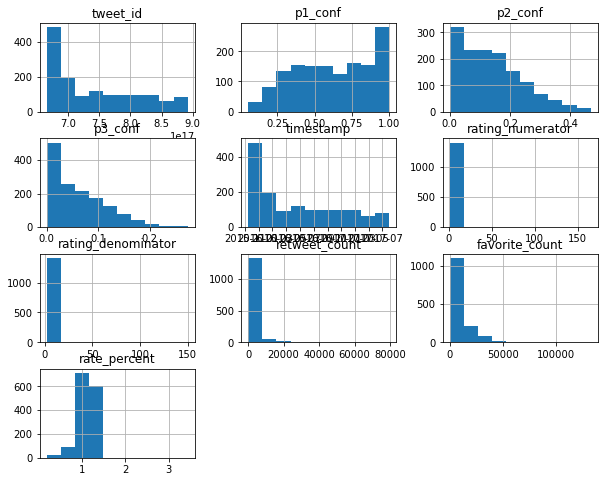

In [69]:
df_master.hist(figsize=(10,8))

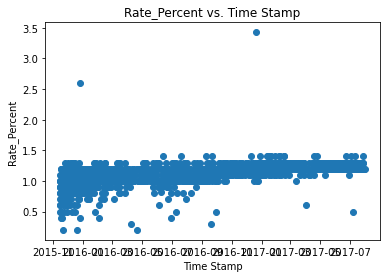

In [70]:
#copied my code from the investigate_a_dataset project
import matplotlib.pyplot as plt
def scatter (x, y, a, b):
    plt.scatter(x, y)
    plt.title( b + " vs. " + a)
    plt.xlabel(a)
    plt.ylabel(b)

scatter(df_master.timestamp, df_master.rate_percent, "Time Stamp", "Rate_Percent")

In [71]:
df_master.describe()

,tweet_id,p1_conf,p2_conf,p3_conf,rating_numerator,rating_denominator,retweet_count,favorite_count,rate_percent
count,1.423000e+03,1423.000000,1423.000000,1.423000e+03,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000
mean,7.416661e+17,0.623889,0.139027,6.051910e-02,11.431483,10.470836,2861.276177,9504.809557,1.092795
std,6.856772e+16,0.258347,0.103089,5.292018e-02,7.026726,6.216813,4854.650896,12789.497836,0.188930
min,6.660209e+17,0.055379,0.000023,2.160900e-07,1.000000,2.000000,16.000000,81.000000,0.200000
25%,6.784352e+17,0.407066,0.054268,1.323450e-02,10.000000,10.000000,662.500000,2260.000000,1.000000
50%,7.174218e+17,0.626236,0.121988,4.854950e-02,11.000000,10.000000,1489.000000,4640.000000,1.100000
75%,7.970513e+17,0.862308,0.201686,9.467765e-02,12.000000,10.000000,3368.000000,12190.500000,1.200000
max,8.918152e+17,0.999956,0.467678,2.734190e-01,165.000000,150.000000,79515.000000,132810.000000,3.428571


In [72]:
import statsmodels.api as sm

df_master['intercept'] = 1

lm = sm.OLS(df_master['rate_percent'], df_master[['intercept','retweet_count', 'favorite_count']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rate_percent   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     158.0
Date:                Fri, 12 Aug 2022   Prob (F-statistic):           1.15e-62
Time:                        10:58:03   Log-Likelihood:                 495.53
No. Observations:                1423   AIC:                            -985.1
Df Residuals:                    1420   BIC:                            -969.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          1.0307      0.006    179.844      0.000       1.019       1.042
retweet_count  -1.459e-05   2.27e-06     -6.423      0.000    -1.9e-05   -1.01e-05
favorite_count  1.092e-05   8.62e-07     12.672      0.000    9.23e-06    1.26e-05
==============================================================================
Omnibus:                      661.810   Durbin-Watson:                   1.779
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            63026.712
Skew:                           1.216   Prob(JB):                         0.00
Kurtosis:                      35.513   Cond. No.                     2.12e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [73]:
#to run a regression I made a copy of the master needed columns and changed the columns to 0's and 1's
df_master_copy = df_master.copy()

In [74]:
df_master_copy['intercept'] = 1

#based code off of https://www.statology.org/pandas-convert-boolean-to-int/#:~:text=You%20can%20use%20the%20following%20basic%20syntax%20to,Pandas%20Suppose%20we%20have%20the%20following%20pandas%20DataFrame%3A
df_master_copy['doggo'] = df_master_copy.doggo.replace({'doggo':1, '':0})
df_master_copy['floofer'] = df_master_copy.floofer.replace({'floofer':1, '':0})
df_master_copy['pupper'] = df_master_copy.pupper.replace({'pupper':1, '':0})
df_master_copy['puppo'] = df_master_copy.puppo.replace({'puppo':1, '':0})


In [75]:
lm = sm.OLS(df_master_copy['rate_percent'], df_master_copy[['intercept','doggo','floofer','pupper','puppo']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rate_percent   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     6.727
Date:                Fri, 12 Aug 2022   Prob (F-statistic):           2.31e-05
Time:                        10:58:03   Log-Likelihood:                 365.98
No. Observations:                1423   AIC:                            -722.0
Df Residuals:                    1418   BIC:                            -695.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0857      0.005    201.434      0.000       1.075       1.096
doggo          0.1060      0.026      4.144      0.000       0.056       0.156
floofer        0.0849      0.071      1.194      0.233      -0.055       0.224
pupper         0.0086      0.016      0.527      0.598      -0.023       0.041
puppo          0.1192      0.043      2.752      0.006       0.034       0.204
==============================================================================
Omnibus:                      481.458   Durbin-Watson:                   1.441
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27778.394
Skew:                           0.742   Prob(JB):                         0.00
Kurtosis:                      24.594   Cond. No.                         14.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Insights:
1. From the line chart (below), it appears that there is a slight increase in ratings as time goes on. This may be indicative of the increase popularity of dogs or the increase in cuter dog submissions.

2. When looking at the correlation between ratings and retweet/ favorite counts, in general the average rate percent would be 1.0307. It appears that dogs that are lower in rated tend to be retweeted more as per 1,000 retweets, the rating is lower by .01459. Additionally, dogs that are higher in rated percent tend to be favorited more as per 1,000 favorites, the rating is higher by .01092. Both of these correlations appear to be statistically significant as the p-values are below 0.05.

3. When there is no indication of the key works (doggo, floofer, pupper, or puppo) the average rating for the dog is 1.08. When adding doggo or puppo into the description, the rating increases by .1060 and .1192, respectively. Additionally both of these are statistically significant as the p-value is below .05%. However, when the terms floofer or pupper were used to the descriptions, the rating may increase by .0849 and .0086, respectively. Though, these are not statistically significant as their p-values are above .05.

### Visualization

In [76]:
df_line = df_master.copy()

df_line = df_line[['rate_percent', 'timestamp']]

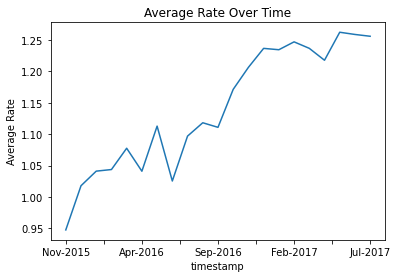

In [77]:
#based code off of https://stackoverflow.com/questions/64756405/how-to-count-amount-of-values-by-month-then-chart-in-a-line-chart
df_line.groupby(pd.to_datetime(df_line['timestamp']).dt.strftime('%b-%Y'), sort=False)['rate_percent'].mean().plot(title = 'Average Rate Over Time', ylabel = 'Average Rate')
plt.savefig('line_chart.png')